In [11]:
import pathlib

import aiapy.calibrate
import astropy.units as u
import astropy.table
import astropy.wcs
import numpy as np
import sunpy.map
import eispac.core
from astropy.coordinates import SkyCoord
from astropy.visualization import ImageNormalize, AsinhStretch
from sunpy.coordinates import propagate_with_solar_surface, get_horizons_coord, Helioprojective
from sunpy.map.header_helper import _set_instrument_meta
from tqdm import tqdm

# Process AIA Data

The steps we need to apply are:

- Align to common coordinate frame
- Correct degradation
- Normalize by exposure time

As part of the first step, we need to build a common coordinate frame that we want to reproject to and also preserve the time of the original map.

- lvl_num
- quality
- t_obs (this will hold the original date)

In [2]:
ar_table = astropy.table.QTable.read('../data/tables/mason_ars_region_1.asdf')

In [3]:
ar_table

<QTable length=3>
NOAA AR ...       EIS file     
        ...                    
 int64  ...        str19       
------- ... -------------------
  11944 ... eis_20140108_095727
  11967 ... eis_20140203_093134
  11990 ... eis_20140302_000659

In [4]:
target_scale = 0.6 * u.arcsec/u.pix
correction_table = aiapy.calibrate.util.get_correction_table()

In [7]:
for row in ar_table:
    print(row['NOAA AR'])
    # Get list of files
    top_dir = pathlib.Path(f'../data/noaa_{row["NOAA AR"]}/AIA/')
    # Build header components
    observer = get_horizons_coord('SDO', row['Date mid'])
    frame = Helioprojective(observer=observer, obstime=observer.obstime)
    blc = row['bottom left']
    trc = row['top right']
    ref_coord = SkyCoord(Tx=(blc[0] + trc[0])/2, Ty=(blc[1] + trc[1])/2, frame=frame)
    shape = u.Quantity([trc[1] - blc[1], trc[0] - blc[0]]) / target_scale
    shape = np.ceil(shape.to_value('pixel')).astype(int).tolist()
    # Get list of files
    file_list = sorted((top_dir / 'level_1').glob(f'aia.lev1_euv_12s.*.image.fits'))
    for file in tqdm(file_list):
        m_l1 = sunpy.map.Map(file)
        target_header = sunpy.map.make_fitswcs_header(
            shape,
            ref_coord,
            scale=u.Quantity([target_scale,target_scale]),
            rotation_angle=0*u.deg,
            instrument=m_l1.meta['instrume'],
            telescope=m_l1.meta['telescop'],
            wavelength=m_l1.wavelength,
            exposure=m_l1.exposure_time,
            unit=m_l1.unit,
        )
        # Add extra keys
        target_header['lvl_num'] = 2
        target_header['quality'] = m_l1.meta['quality']
        target_header['t_obs'] = m_l1.date.isot
        target_header['rsun_ref'] = m_l1.meta['rsun_ref']  # needed for reprojection
        # Reproject
        #target_wcs = astropy.wcs.WCS(header=target_header)
        with propagate_with_solar_surface():
            m_l2 = m_l1.reproject_to(target_header, parallel=False)
        m_l2 = sunpy.map.Map(m_l2.data, target_header)
        # Additional prep steps
        m_l2 = aiapy.calibrate.correct_degradation(m_l2, correction_table=correction_table)
        m_l2 = m_l2 / m_l2.exposure_time
        # Save to L2 dir
        file_l2 = top_dir / 'level_2' / file.name.replace('lev1', 'lev2')
        m_l2.save(file_l2, overwrite=True)

11944
INFO: Obtained JPL HORIZONS location for Solar Dynamics Observatory (spac [sunpy.coordinates.ephemeris]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4326/4326 [42:52<00:00,  1.68it/s]


11967
INFO: Obtained JPL HORIZONS location for Solar Dynamics Observatory (spac [sunpy.coordinates.ephemeris]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4326/4326 [45:54<00:00,  1.57it/s]


11990
INFO: Obtained JPL HORIZONS location for Solar Dynamics Observatory (spac [sunpy.coordinates.ephemeris]


 25%|████████████████████████████████▉                                                                                                   | 1080/4326 [08:39<24:51,  2.18it/s]/Users/wtbarnes/mambaforge/envs/loops-2024-talk/lib/python3.12/site-packages/astropy/units/quantity.py:671: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/wtbarnes/mambaforge/envs/loops-2024-talk/lib/python3.12/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
 25%|████████████████████████████████▉                                                                                                   | 1081/4326 [08:39<25:21,  2.13it/s]/Users/wtbarnes/mambaforge/envs/loops-2024-talk/lib/python3.12/site-packages/astropy/units/quantity.py:671: RuntimeWarning: divide by zero encountered in divide
  result = super().__array

Now reproject all of the files also to the corresponding EIS FOV. This makes computing the correlations easier.

In [9]:
m_eis_ref = sunpy.map.Map('../data/noaa_11944/EIS/level_2.5/eis_*.fe_12_195_119.2c-0.int.fits')

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


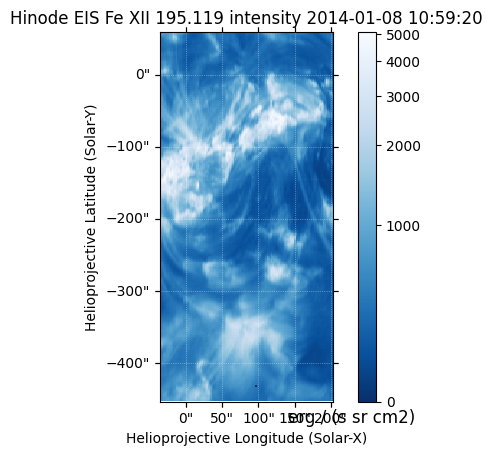

In [10]:
m_eis_ref.peek()

In [18]:
import sunpy
sunpy.log.setLevel('WARN')

In [19]:
for row in ar_table:
    print(row['NOAA AR'])
    # Get list of files
    top_dir = pathlib.Path(f'../data/noaa_{row["NOAA AR"]}/')
    # Load EIS file
    m_eis_ref = sunpy.map.Map(top_dir / 'EIS' / 'level_2.5' / 'eis_*.fe_12_195_119.2c-0.int.fits')
    # Get list of files
    file_list = sorted((top_dir / 'AIA' / 'level_1').glob(f'aia.lev1_euv_12s.*.image.fits'))
    for file in tqdm(file_list):
        m_l1 = sunpy.map.Map(file)
        # Additional prep steps
        m_l1 = aiapy.calibrate.correct_degradation(m_l1, correction_table=correction_table)
        m_l1 = m_l1 / m_l1.exposure_time
        m_l1.meta['rsun_ref'] = m_eis_ref.rsun_meters.to_value('meter')
        # Reproject
        with propagate_with_solar_surface():
            m_l2 = m_l1.reproject_to(m_eis_ref.wcs, parallel=False)
        target_header = m_l2.meta.copy()
        # Propagate relevant non-WCS AIA metadata
        target_header = _set_instrument_meta(target_header,
                                             m_l1.meta['instrume'],
                                             m_l1.meta['telescop'],
                                             None,
                                             None,
                                             m_l1.wavelength,
                                             m_l1.exposure_time,
                                             m_l1.unit)
        target_header['lvl_num'] = 2
        target_header['quality'] = m_l1.meta['quality']
        target_header['t_obs'] = m_l1.date.isot
        m_l2 = sunpy.map.Map(m_l2.data, target_header)
        # Save to L2 dir
        l2eis_dir = top_dir / 'AIA' / 'level_2_EIS'
        l2eis_dir.mkdir(exist_ok=True)
        m_l2.save(l2eis_dir / file.name.replace('lev1', 'lev2eis'), overwrite=True)

11944


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4326/4326 [08:59<00:00,  8.03it/s]


11967


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4326/4326 [08:56<00:00,  8.07it/s]


11990


 25%|████████████████████████████████▉                                                                                                   | 1080/4326 [01:25<04:09, 13.03it/s]/Users/wtbarnes/mambaforge/envs/loops-2024-talk/lib/python3.12/site-packages/astropy/units/quantity.py:671: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/wtbarnes/mambaforge/envs/loops-2024-talk/lib/python3.12/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/wtbarnes/mambaforge/envs/loops-2024-talk/lib/python3.12/site-packages/astropy/units/quantity.py:671: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/wtbarnes/mambaforge/envs/loops-2024-talk/lib/python3.12/site-packages/astropy/units/quantity.py:671: RuntimeWarning: inv

In [18]:
from IPython.display import HTML

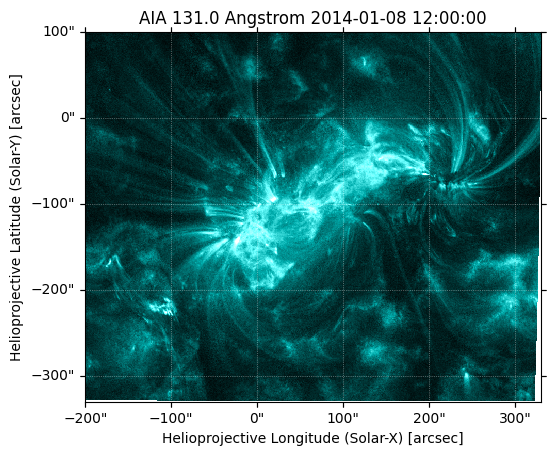

In [23]:
HTML(foo.plot(norm=ImageNormalize(vmin=0,vmax=2e2, stretch=AsinhStretch())).to_jshtml())

In [7]:
len(list(pathlib.Path('../data/noaa_11944/AIA/level_1').glob('aia.lev1_euv_12s.*.131.image.fits'))) * 6

4326